In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [82]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [83]:
# Load dataset
df = pd.read_csv('2.csv', encoding='latin-1')

In [84]:
# Keep only target and text columns
df = df[['Score', 'Text']]


In [85]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [86]:
df.shape

(10000, 2)

In [87]:
df.count()

Score    10000
Text     10000
dtype: int64

**pre processing**


In [88]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['Text'].apply(clean_text)
print(df[['Text', 'clean_text']].head())


                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                          clean_text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around centuries light pillowy citr...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


In [89]:
def NER(text):
     doc = nlp(text)
     return [(ent.text,ent.label_) for ent in doc.ents]

df['entities'] = df['Text'].head().apply(NER)
print(df[['entities', 'Text']].head())

                                            entities  \
0           [(Vitality, ORG), (My Labrador, PERSON)]   
1        [(Jumbo Salted, ORG), (Jumbo, WORK_OF_ART)]   
2  [(around a few centuries, DATE), (pillowy citr...   
3  [(Robitussin, GPE), (the Root Beer Extract I, ...   
4                               [(Delivery, PERSON)]   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [90]:
def get_sent(text):
    return TextBlob(text).sentiment.polarity
df['sentiment']=df['Text'].apply(get_sent)
print(df[['Text', 'sentiment']].head())

                                                Text  sentiment
0  I have bought several of the Vitality canned d...   0.450000
1  Product arrived labeled as Jumbo Salted Peanut...  -0.033333
2  This is a confection that has been around a fe...   0.133571
3  If you are looking for the secret ingredient i...   0.166667
4  Great taffy at a great price.  There was a wid...   0.483333


In [91]:
# # Map sentiment: <0 → 0 (negative), >0→ 1 (positive)
df['target'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)
print (df[['Text','target']].head())

                                                Text  target
0  I have bought several of the Vitality canned d...       1
1  Product arrived labeled as Jumbo Salted Peanut...       0
2  This is a confection that has been around a fe...       1
3  If you are looking for the secret ingredient i...       1
4  Great taffy at a great price.  There was a wid...       1


In [92]:
X = df['clean_text']
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [93]:
# Train logistic
model = LogisticRegression(max_iter=2000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[  15  225]
 [   1 1759]]
              precision    recall  f1-score   support

           0       0.94      0.06      0.12       240
           1       0.89      1.00      0.94      1760

    accuracy                           0.89      2000
   macro avg       0.91      0.53      0.53      2000
weighted avg       0.89      0.89      0.84      2000



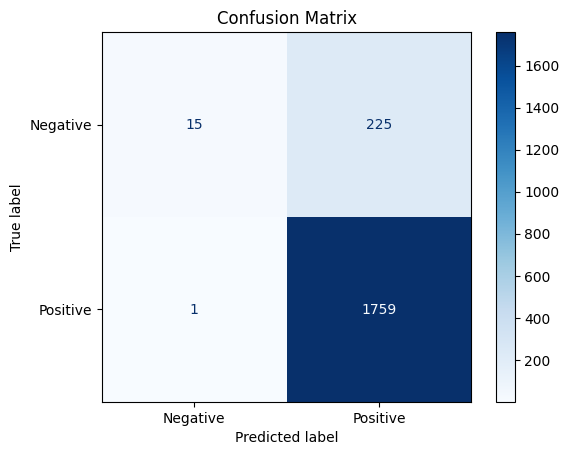

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [95]:
# #train RFC
# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train_vec, y_train)

# # Predict
# y_pred = model.predict(X_test_vec)

# # Evaluation
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [96]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()


In [97]:
import joblib

# Save model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [98]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)
    return 'Positive' if prediction[0] == 1 else 'Negative'

# Example
print(predict_sentiment("l love this!"))
print(predict_sentiment("taste food is bad."))


Positive
Negative
